In [45]:
import lasio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sys import stdout
from openpyxl import Workbook


w1 = r'.\DATOS_EDITADOS\SNRG-0001_FINAL.las'
w2 = r'./Well_Logging/SNRG-0002_basic_logs.las'
w3 = r'./Well_Logging/SNRG-0003_basic_logs.las'
w4 = r'./Well_Logging/SNRG-0004_basic_logs.las'


In [46]:
las_1 = lasio.read(w1)
# las_1.to_csv(stdout)
df = las_1.df()
df.reset_index(inplace =True)
# df.to_excel("Registro_4.xlsx",sheet_name="Registro_4_Limpio",index=False)

In [47]:
#Cambio de nombres para diferentes tipos de cabezales
if "GRGC" in df:
    df = df.rename(columns={'GRGC':'GR'})
if ("RHOB" or "RHOZ") in df:
    df = df.rename(columns={'RHOB':'DEN'})
    df = df.rename(columns={'RHOZ':'DEN'})
if ("NPHI") in df:
    df = df.rename(columns={'NPHI':'NEU'})
if ("DDLL" or "AT90" or "RT" or "ILD") in df:
    df = df.rename(columns={'DDLL':'AT90'})
    df = df.rename(columns={'AT90':'AT90'})
    df = df.rename(columns={'RT':'AT90'})
    df = df.rename(columns={'IDL':'AT90'})
if ("PDPE" or "PEFZ") in df:
    df = df.rename(columns={'PDPE':'PEF'})
    df = df.rename(columns={'PEFZ':'PEF'})
df

,DEPTH,AT90,BIT,DCOR,DEN,DSLL,DT35,GR,NEU,NPRD,NPRL,NPRS,PEF,TOC
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,8998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17997,8998.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17998,8999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17999,8999.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


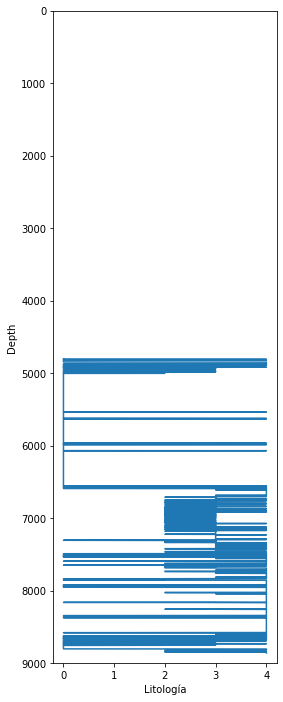

In [48]:
# Identifciación de los valores maximos y minimos del gamma ray
GR_max = df['GR'].max()
GR_min = df['GR'].min()

#Identificación de shale del resto de litologías
df.loc[df.GR>80,'Shale']= 0
df.loc[df.GR<80,'Shale']= 1

#Identificación de litologias mediante Neutron y Gamma Ray
df["Lit_ND"] = (df["DEN"] - 1.95) - (1 - (5/3)*(df["NEU"]+0.15))

# #Creación de la gráfica de litología
# fig , axs = plt.subplots(figsize=(4,12))
# plt.plot(df['Lit_ND'],df['DEPTH'])
# plt.xlabel('Litología')
# plt.ylabel('Depth')
# plt.ylim(max(df['DEPTH']),min(df['DEPTH']))
# # fig.savefig("DEPTH_vs_Lit_ND.png")

#Creacion de la litología con curvas
# Si es menor -0.03 Arenisca  2
df.loc[df.Lit_ND < -0.03,'Litologia']= 2
# Si esta en el rango de -0.03 a 0.03 limolita 3
df.loc[df.Lit_ND >= -0.03,'Litologia']= 3
#Si es mayor a 0.03 Dolomita 4
df.loc[df.Lit_ND > 0.03,'Litologia']= 4


df['Litologia'] = df['Litologia'] * df['Shale']

df
# # #Creación de la gráfica de litología
fig , axs = plt.subplots(figsize=(4,12))
plt.plot(df['Litologia'],df['DEPTH'])
plt.xlabel('Litología')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH']),min(df['DEPTH']))
# # fig.savefig("DEPTH_vs_Lit_ND.png")

df.to_excel('registro_prueba.xlsx',sheet_name='prueba',index=False)

In [49]:
#Asignacion de fila de matriz density
df.loc[df.Litologia == 0,'Matrix_DEN']= 2.65
df.loc[df.Litologia == 2,'Matrix_DEN']= 2.654
df.loc[df.Litologia == 3,'Matrix_DEN']= 2.711
df.loc[df.Litologia == 4,'Matrix_DEN']= 2.87


In [50]:
#Calculo de volumen de kerogeno
df['VolK'] = (1.19 * df['TOC'] * df['DEN'])/( 100 * 1.24)

#Correcion de densidad por TOC
df.loc[df.TOC != 0,'DEN_K'] = (df['DEN'] - (1.24 * df['VolK'] )) / ( 1 - df['VolK'])

#Porosidad del kerogeno
df['Poro_K'] = 0.2 * df['TOC'] * df['DEN']

In [51]:
#Porosidad density total
df.loc[df.DEN > 0,'Density'] = ((df['Matrix_DEN']-df['DEN'])/(df['Matrix_DEN']-1))
df.loc[df.DEN_K > 0,'Density'] = ((df['Matrix_DEN']-df['DEN_K'])/(df['Matrix_DEN']-1)) + df['Poro_K']

# Corrección de valores negativos
df.loc[df.Density > 0 ,'DEN_TOTAL'] = ""
df.loc[df.Density > 0 ,'DEN_TOTAL'] = df['Density']

#Porosidad Total Neutron mas density
df['Total_Poro'] = ( df['NEU'] + df['DEN_TOTAL'])/2

In [52]:
#Calculo de la temperatura de la formacion
df.loc[df.DEPTH <= 100,'Temperature'] = 75
df.loc[df.DEPTH > 100,'Temperature'] = 75 + (0.74 * (df['DEPTH'] - 100) / 100)

In [56]:
#Cálculo de la resistividad de la formación
df.loc[df.DEPTH > 100,'RES_CORR'] = 0.2 * ( 75 + 6.77) / ( df['Temperature'] + 6.77 )

In [66]:
#Calculo de IGR
GR = df['GR']
IGR = (GR-GR_min)/(GR_max-GR_min)
df['Vclay']= 1.7 - (3.38-(IGR+0.7)**2)**0.5
df.head(11000)

,DEPTH,AT90,BIT,DCOR,DEN,DSLL,DT35,GR,NEU,NPRD,...,Matrix_DEN,VolK,DEN_K,Poro_K,Density,DEN_TOTAL,Total_Poro,Temperature,RES_CORR,Vclay
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0000,NaN,NaN
1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0000,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0000,NaN,NaN
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0000,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,5497.5,41.965,7.875,0.040,2.680,42.916,63.519,116.868,0.1292,11.493,...,2.65,NaN,NaN,NaN,-0.018182,NaN,NaN,114.9415,0.134367,0.360937
10996,5498.0,41.830,7.875,0.041,2.666,43.691,63.346,119.308,0.1240,11.005,...,2.65,NaN,NaN,NaN,-0.009697,NaN,NaN,114.9452,0.134363,0.372884
10997,5498.5,40.344,7.875,0.049,2.649,42.441,63.782,129.361,0.1267,11.256,...,2.65,NaN,NaN,NaN,0.000606,0.000606,0.063653,114.9489,0.134359,0.424594
10998,5499.0,38.388,7.875,0.059,2.629,40.103,64.887,137.619,0.1363,12.154,...,2.65,NaN,NaN,NaN,0.012727,0.012727,0.074514,114.9526,0.134355,0.470327


<AxesSubplot:xlabel='GR'>

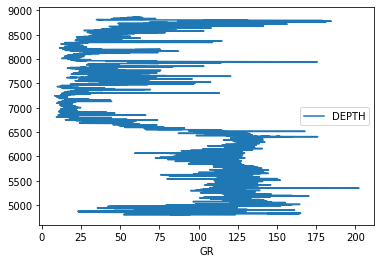

In [ ]:
df.plot(x='GR',y='DEPTH',)

In [63]:
#Calculo de IGR
IGR = (GR-GR_min)/(GR_max-GR_min)
df['Vclay']= 1.7 - ( 3.38 -( IGR + 0.7) ** 2 ) ** 0.5
IGR.head()



0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: GR, dtype: float64

<AxesSubplot:xlabel='NEU'>

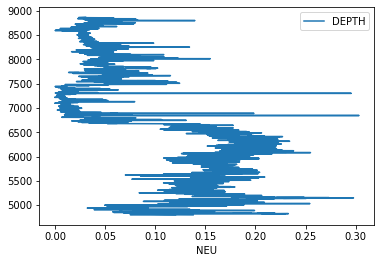

In [ ]:
df.plot.line(x='NEU',y='DEPTH')

(9000.0, 0.0)

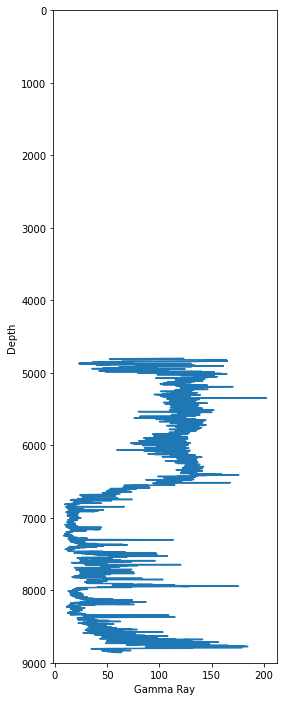

In [ ]:
fig , axs = plt.subplots(figsize=(4,12))
plt.plot(df['GR'],df['DEPTH'])
plt.xlabel('Gamma Ray')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH']),min(df['DEPTH']))
# fig.savefig("Gammaray.png")


In [1]:
# fig, axs = plt.subplots(figsize=(30,10))
# df.plot(x='DEPTH:1',ax = axs,figsize=(30,10),subplots=True)
# fig.savefig("Resumen de registros.png")

(9000.0, 0.0)

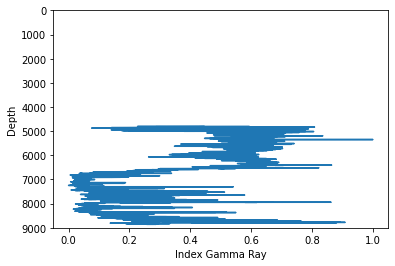

In [ ]:
df['IGR'] = (df['GR']-GR_min)/(GR_max-GR_min)
df['Vshale'] = 1.7 - (3.38-(df['IGR']+0.7**2))**0.5
plt.plot(df['IGR'],df['DEPTH:1'])
plt.xlabel('Index Gamma Ray')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))

(9000.0, 0.0)

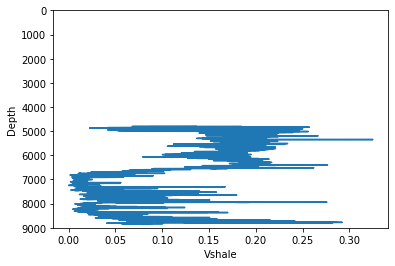

In [ ]:
plt.plot(df['Vshale'],df['DEPTH:1'])
plt.xlabel('Vshale')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))

In [ ]:
# df.to_excel("Registro_1.xlsx",sheet_name="Registro_1",index=False)
df

,DEPTH,AT90,BIT,DCOR,DEN,DSLL,DT35,GR,NEU,NPRD,NPRL,NPRS,PEF,TOC,Shale,Lit_ND,Litologia
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,8998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17997,8998.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17998,8999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17999,8999.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
